# Current Trends in Bioinformatics Software Development and Archiving

In [1]:
from datetime import datetime
import json
import re
import time

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import requests
import warnings
import xmltodict

%reload_ext autoreload
%autoreload 2
import pbmd_tools as pbmd

In [2]:
pbmd.read_tokens()
GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN")
PUBMED_TOKEN = os.environ.get("PUBMED_TOKEN")

## 1. PubMed API Entrez Interactions

In [3]:
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "json"
queries_github = []
queries_gitlab = []
queries_sourceforge = []
queries_googlecode = []
queries_bitbucket = []
for year in range(2009,2023):
    queries_github.append(f'((github.com[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_gitlab.append(f'((gitlab.com[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_sourceforge.append(f'((sourceforge.net[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_googlecode.append(f'(googlecode[Title/Abstract]) AND ("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication])')
    queries_bitbucket.append(f'(bitbucket.org[Title/Abstract]) AND ("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication])')

In [4]:
stats_github = {}
stats_gitlab = {}
stats_sourceforge = {}
stats_googlecode = {}
stats_bitbucket = {}
PMIDs = []
PMIDs_all = []
for query in tqdm(queries_github):
    nb = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        if id not in PMIDs:
            nb += 1
            PMIDs.append(id)
    stats_github[query[38:42]] = nb
for query in tqdm(queries_bitbucket):
    nb = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        if id not in PMIDs_all:
            nb += 1
            PMIDs_all.append(id)
    stats_bitbucket[query[38:42]] = nb
for query in tqdm(queries_gitlab):
    nb = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        if id not in PMIDs_all:
            nb += 1
            PMIDs_all.append(id)
    stats_gitlab[query[38:42]] = nb
for query in tqdm(queries_sourceforge):
    nb = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        if id not in PMIDs_all:
            nb += 1
            PMIDs_all.append(id)
    stats_sourceforge[query[43:47]] = nb
for query in tqdm(queries_googlecode):
    nb = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        if id not in PMIDs_all:
            nb += 1
            PMIDs_all.append(id)
    stats_googlecode[query[19:23]] = nb

print(f"\n{len(PMIDs)} articles with 'github.com' found in PubMed")
PMIDs = list(set(PMIDs))
print(f"\n{len(PMIDs)} articles with 'github.com' found in PubMed")

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s]


10880 articles with 'github.com' found in PubMed

10880 articles with 'github.com' found in PubMed


In [65]:
with open("PMIDs.txt", "w") as f:
    for PMID in PMIDs:
        f.write(str(PMID)+"\n")
with open("stats_github.json", "w") as f:
    json.dump(stats_github, f)
with open("stats_gitlab.json", "w") as f:
    json.dump(stats_gitlab, f)
with open("stats_sourceforge.json", "w") as f:
    json.dump(stats_sourceforge, f)    
with open("stats_googlecode.json", "w") as f:
    json.dump(stats_googlecode, f)

In [66]:
with open("stats_github.json", "r") as f:
    stats_github = json.load(f)
with open("stats_gitlab.json", "r") as f:
    stats_gitlab = json.load(f)
with open("stats_sourceforge.json", "r") as f:
    stats_sourceforge = json.load(f)
with open("stats_googlecode.json", "r") as f:
    stats_googlecode = json.load(f)
with open("PMIDs.txt", "r") as f:
    PMIDs = f.readlines()
PMIDs = [PMID.strip() for PMID in PMIDs]

C:\Users\nadia\AppData\Local\Temp\ipykernel_11024\1426008358.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,1].set_xticklabels(years, rotation=70)


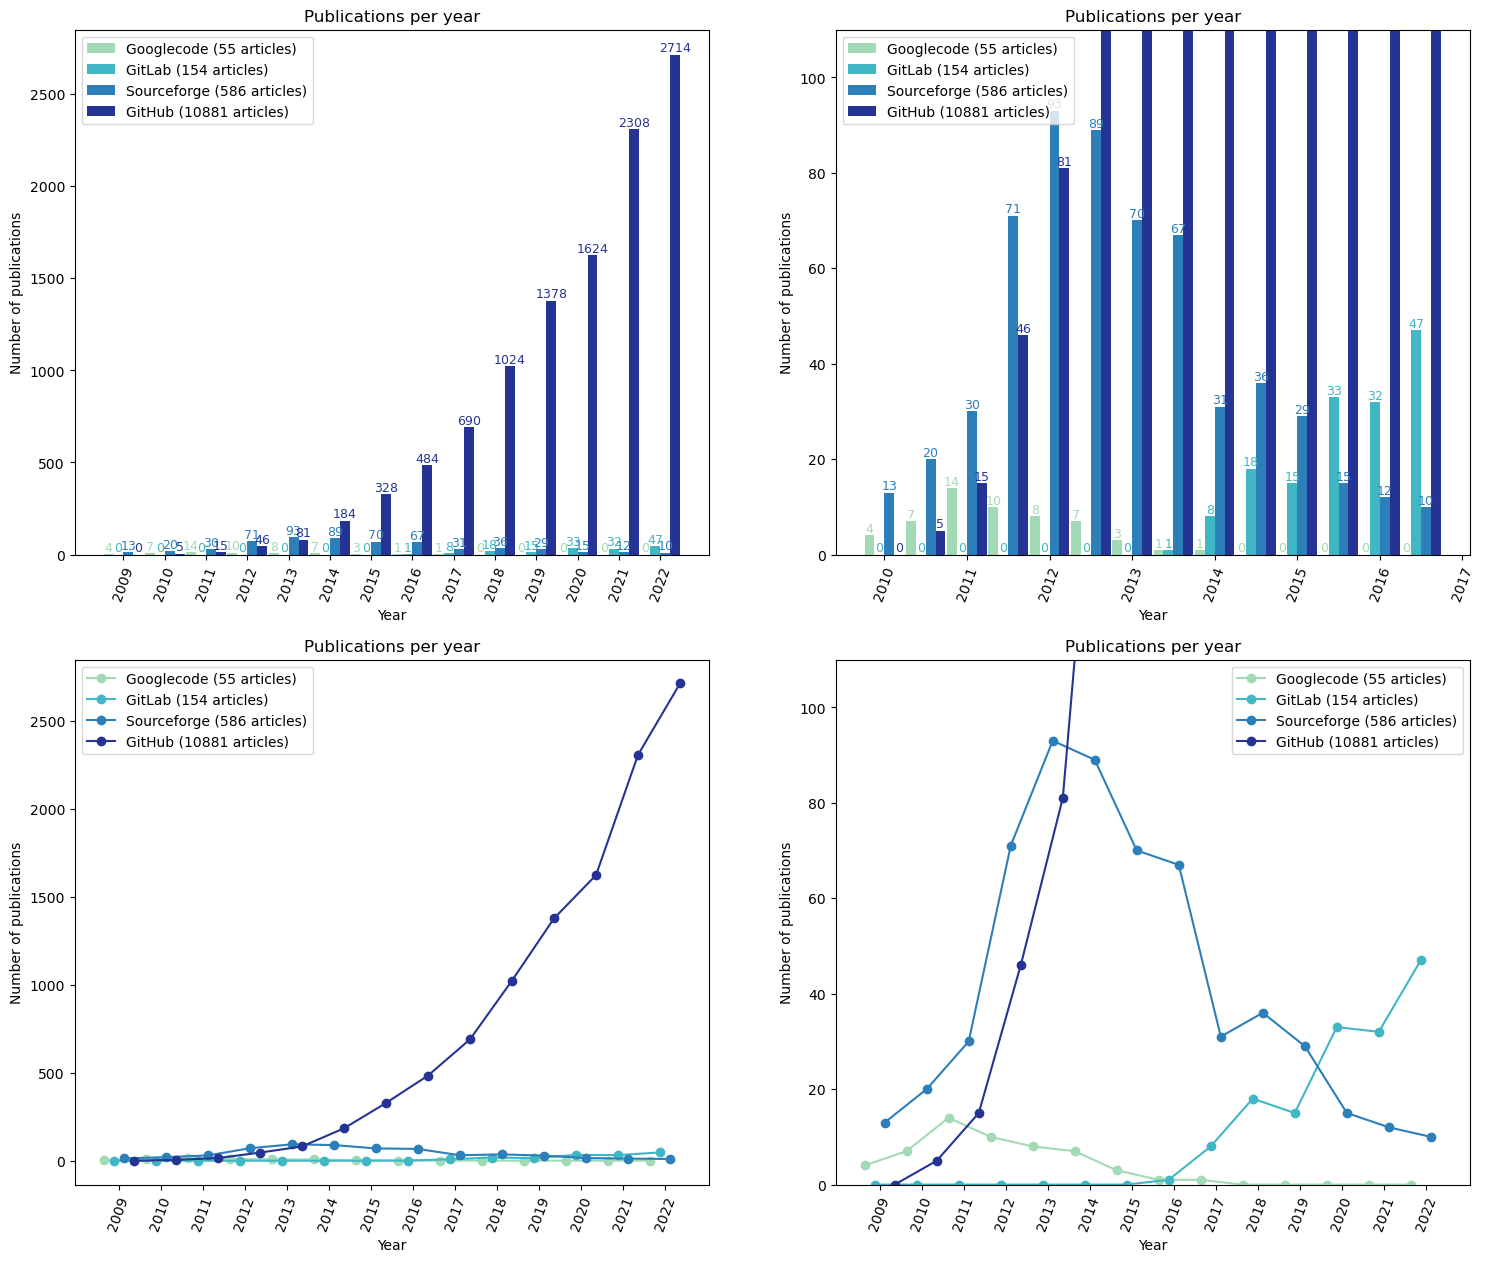

In [68]:
fig, ax = plt.subplots(2,2, figsize=(18, 15))

years = list(stats_github.keys())
    
values_github = list(stats_github.values())
values_gitlab = list(stats_gitlab.values())
values_sourceforge = list(stats_sourceforge.values())
values_googlecode = list(stats_googlecode.values())

bar_width = 0.24
x_pos = np.arange(len(years)) 


ax[0,0].bar(x_pos - bar_width*3/2, values_googlecode, width=bar_width, color='#a1dab4',  zorder=2)
ax[0,0].bar(x_pos - bar_width*1/2, values_gitlab, width=bar_width, color='#41b6c4',  zorder=2)
ax[0,0].bar(x_pos + bar_width*1/2, values_sourceforge, width=bar_width, color='#2c7fb8', zorder=2)
ax[0,0].bar(x_pos + bar_width*3/2, values_github, width=bar_width, color='#253494', zorder=2)

ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Number of publications')
ax[0,0].set_title('Publications per year')
ax[0,0].set_xticks(x_pos)
ax[0,0].set_xticklabels(years, rotation=70)

ax[0,0].legend([f'Googlecode ({sum(values_googlecode)} articles)', f'GitLab ({sum(values_gitlab)} articles)', 
           f'Sourceforge ({sum(values_sourceforge)} articles)', f'GitHub ({sum(values_github)} articles)'])

for i in range(len(years)):
    ax[0,0].text(i-bar_width*3/2, values_googlecode[i], str(values_googlecode[i]), ha='center', va='bottom', fontsize=9, color='#a1dab4')
    ax[0,0].text(i-bar_width/2, values_gitlab[i], str(values_gitlab[i]), ha='center', va='bottom', fontsize=9, color='#41b6c4')
    ax[0,0].text(i+bar_width/2, values_sourceforge[i], str(values_sourceforge[i]), ha='center', va='bottom', fontsize=9, color='#2c7fb8')
    ax[0,0].text(i+bar_width*3/2, values_github[i], str(values_github[i]), ha='center', va='bottom', fontsize=9, color='#253494')

ax[0,1].bar(x_pos - bar_width*3/2, values_googlecode, width=bar_width, color='#a1dab4',  zorder=2)
ax[0,1].bar(x_pos - bar_width*1/2, values_gitlab, width=bar_width, color='#41b6c4',  zorder=2)
ax[0,1].bar(x_pos + bar_width*1/2, values_sourceforge, width=bar_width, color='#2c7fb8', zorder=2)
ax[0,1].bar(x_pos + bar_width*3/2, values_github, width=bar_width, color='#253494', zorder=2)

ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('Number of publications')
ax[0,1].set_title('Publications per year')
ax[0,1].set_xticklabels(years, rotation=70)

ax[0,1].legend([f'Googlecode ({sum(values_googlecode)} articles)', f'GitLab ({sum(values_gitlab)} articles)', 
           f'Sourceforge ({sum(values_sourceforge)} articles)', f'GitHub ({sum(values_github)} articles)'])

for i in range(len(years)):
    if values_github[i] <  110:
        ax[0,1].text(i+bar_width*3/2, values_github[i], str(values_github[i]), ha='center', va='bottom', fontsize=9, color='#253494')
    ax[0,1].text(i-bar_width*3/2, values_googlecode[i], str(values_googlecode[i]), ha='center', va='bottom', fontsize=9, color='#a1dab4')
    ax[0,1].text(i-bar_width/2, values_gitlab[i], str(values_gitlab[i]), ha='center', va='bottom', fontsize=9, color='#41b6c4')
    ax[0,1].text(i+bar_width/2, values_sourceforge[i], str(values_sourceforge[i]), ha='center', va='bottom', fontsize=9, color='#2c7fb8')


ax[0,1].set_ylim(0, 110)


ax[1,0].plot(x_pos - bar_width*3/2, values_googlecode,  marker='o', color='#A6CEE3',  zorder=2)
ax[1,0].plot(x_pos - bar_width*1/2, values_gitlab,  marker='o', color='#1F78B4',  zorder=2)
ax[1,0].plot(x_pos + bar_width*1/2, values_sourceforge,  marker='o', color='#33A02C', zorder=2)
ax[1,0].plot(x_pos + bar_width*3/2, values_github,  marker='o', color='#FB9A99', zorder=2)

ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Number of publications')
ax[1,0].set_title('Publications per year')
ax[1,0].set_xticks(x_pos)
ax[1,0].set_xticklabels(years, rotation=70)

ax[1,0].legend([f'Googlecode ({sum(values_googlecode)} articles)', f'GitLab ({sum(values_gitlab)} articles)', 
           f'Sourceforge ({sum(values_sourceforge)} articles)', f'GitHub ({sum(values_github)} articles)'])

#for i in range(len(years)):
#    ax[1,0].text(i+bar_width*3/2-0.3, values_github[i]+15, str(values_github[i]), ha='center', va='bottom', fontsize=9, color='#253494')

ax[1,1].plot(x_pos - bar_width*3/2, values_googlecode,  marker='o', color='#A6CEE3',  zorder=2)
ax[1,1].plot(x_pos - bar_width*1/2, values_gitlab,  marker='o', color='#1F78B4',  zorder=2)
ax[1,1].plot(x_pos + bar_width*1/2, values_sourceforge,  marker='o', color='#33A02C', zorder=2)
ax[1,1].plot(x_pos + bar_width*3/2, values_github,  marker='o', color='#FB9A99', zorder=2)

ax[1,1].set_xlabel('Year')
ax[1,1].set_ylabel('Number of publications')
ax[1,1].set_title('Publications per year')
ax[1,1].set_xticks(x_pos)
ax[1,1].set_xticklabels(years, rotation=70)

ax[1,1].legend([f'Googlecode ({sum(values_googlecode)} articles)', f'GitLab ({sum(values_gitlab)} articles)', 
           f'Sourceforge ({sum(values_sourceforge)} articles)', f'GitHub ({sum(values_github)} articles)'])

# adding numbers for each point

#for i in range(len(years)):
#    if values_github[i] <  110:
#        ax[1,1].text(i+bar_width*3/2+0.33, values_github[i]+0.5, str(values_github[i]), ha='center', va='bottom', fontsize=9, color='#253494')
#    ax[1,1].text(i-bar_width*3/2-0.0001, values_googlecode[i]+1, str(values_googlecode[i]), ha='center', va='bottom', fontsize=9, color='#a1dab4')
#    ax[1,1].text(i-bar_width/2-0.0001, values_gitlab[i]+1, str(values_gitlab[i]), ha='center', va='bottom', fontsize=9, color='#41b6c4')
#    ax[1,1].text(i+bar_width/2-0.0001, values_sourceforge[i]+1, str(values_sourceforge[i]), ha='center', va='bottom', fontsize=9, color='#2c7fb8')


ax[1,1].set_ylim(0, 110)
    
    
plt.show()

In [230]:
# https://pubmed.ncbi.nlm.nih.gov/26262258/ - No DOI in PubMed although there is one in the full text of the article (not from ArXiv), and there are a lot of them
# https://pubmed.ncbi.nlm.nih.gov/28269829/ - they give a wrong link https://github.com/SBU-BMI/imageboxs://github.com/SBU-BMI/imagebox but if you use this link :
# https://github.com/SBU-BMI/imagebox it works. Yet, i am not sure that it is actually what we are looking for since they also provide another link to github.io 
# (also incorect) and i think it's more likely that their code is there
# PMID = 36789260 - 2 links
#https://github.com/tyqGitHub/TYQ/tree/master/GACNNMDA - ????
#https://github.com/mofradlab - ?????? (PMID 36786404)
# PMID = 26124555 - a space in the link
# PMID = 24324759, 22151646 - no space after link
# PMID = 23849037 - why + in the end ?
# PMID = 36315552 - super smart

In [72]:
results = []

In [88]:
#count = 0
for PMID in tqdm(PMIDs[:]):
    #count += 1
    #if count % 10 == 0:
    #    time.sleep(1)
    
    summary = pbmd.get_summary(PMID, PUBMED_TOKEN, "status.txt")
    abstract = pbmd.get_abstract_from_summary(summary, "status.txt")
    pubdate = pbmd.get_pubdate_from_summary(summary, "status.txt")
    title = pbmd.get_title_from_summary(summary, "status.txt")
    journal = pbmd.get_journal_from_summary(summary, "status.txt")
    doi = pbmd.get_doi_from_summary(summary, "status.txt")

    results.append((PMID, pubdate, doi, journal, title, abstract))


100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [01:11<00:00,  1.66it/s]


In [94]:
df = pd.DataFrame.from_records(results)
df = df.rename(columns = {0: 'PMID', 1: 'PubDate', 2: 'DOI', 3: 'Journal', 4: 'Title', 5: 'Abstract'})
df = df.drop_duplicates(subset = 'PMID', keep = False)
df = df.reset_index(drop = True)

In [97]:
print(f"Number of records without publication date is: {len(df[df['PubDate'].isnull()])}")

Number of records without publication date is: 58


In [98]:
df.to_csv('articles.tsv', sep='\t', index=False)

## 2. Geting links from the obtained data using regex

In [58]:
df = pd.read_csv('articles.tsv', sep='\t')

In [100]:
df['GitHub_link_raw'] = df['Abstract'].astype(str).apply(pbmd.get_link_from_abstract)
df['GitHub_link_clean'] = df['GitHub_link_raw'].astype(str).apply(pbmd.clean_link)
df['GitHub_owner'] = df['GitHub_link_clean'].apply(pbmd.get_owner_from_link)
df['GitHub_repo'] = df['GitHub_link_clean'].apply(pbmd.get_repo_from_link)

In [105]:
print(f"Number of records with weird abstracts leading to inability to extract a link: {len(df[df['GitHub_link_raw'] == ''])}")

Number of records with weird abstracts leading to inability to extract a link: 6


In [107]:
print(f"Number of records without a repository name: {len(df[df['GitHub_repo'].isnull()])-len(df[df['GitHub_owner'].isnull()])}")

Number of records without a repository name: 251


In [108]:
df.to_csv('articles.tsv', sep='\t', index=False)

## 3. GitHub API Interactions

In [32]:
df = pd.read_csv('articles.tsv', sep='\t')

In [109]:
PMIDs = df['PMID'][df['GitHub_repo'].notna()].to_list()
len(PMIDs)

10624

In [9]:
count = 0
for PMID in tqdm(PMIDs):
    count += 1
    if count % 5000 == 0:
        time.sleep(3600)
    
    with open("gitstat.txt", "a") as f:
        f.write(f"\n\n PMID: {PMID}, GitHub link: {df[df['PMID'] == PMID]['GitHub_link_clean'].values[0]}")

    info = pbmd.get_repo_info(df[df['PMID']==PMID]['GitHub_owner'].values[0], df[df['PMID']==PMID]['GitHub_repo'].values[0], GITHUB_TOKEN, "gitstat.txt")

    idx = df.index[df['PMID'] == PMID][0]

    df.loc[idx, "Repo_created_at"] = pbmd.get_repo_date_created(info)
    df.loc[idx, "Repo_updated_at"] = pbmd.get_repo_date_updated(info)
    df.loc[idx, "Fork"] = pbmd.is_fork(info)

100%|██████████████████████████████████████████████████████████████████████████████| 1077/1077 [05:01<00:00,  3.57it/s]


In [10]:
PMIDs = df['PMID'][df['Repo_created_at'].isna()].to_list()
len(PMIDs)

766

In [13]:
df[df['Repo_created_at'].isna()]

,PMID,PubDate,DOI,Journal,Title,Abstract,GitHub_link_raw,GitHub_link_clean,GitHub_owner,GitHub_repo,Repo_created_at,Repo_updated_at,Fork
0,31944107,2021-06-17,10.1021/acs.jcim.9b01012,Journal of chemical information and modeling,Identification of Highest-Affinity Binding Sit...,Transcription factors (TFs) play a crucial rol...,github.com/guofei-tju/tfbs.,https://github.com/guofei-tju/tfbs/,guofei-tju,tfbs,None,None,1.0
28,30564458,2020-02-06,10.1038/s41540-018-0078-8,NPJ systems biology and applications,"ComPath: an ecosystem for exploring, analyzing...",Although pathways are widely used for the anal...,github.com/ComPath,https://github.com/ComPath/,ComPath,NaN,None,None,0.0
51,28402395,2018-03-29,10.1093/bioinformatics/btx169,"Bioinformatics (Oxford, England)",mzML2ISA & nmrML2ISA: generating enriched ISA-...,"[{'@Label': 'SUMMARY', '@NlmCategory': 'CONCLU...",github.com/ISA-tools.,https://github.com/ISA-tools/,ISA-tools,NaN,None,None,0.0
55,26568629,2017-08-04,10.1093/bioinformatics/btv674,"Bioinformatics (Oxford, England)",Accurate estimation of isoelectric point of pr...,"[{'@Label': 'MOTIVATION', '#text': 'In any mac...",github.com/ypriverol/pIRSupplementary,https://github.com/ypriverol/pIRSupplementary/,ypriverol,pIRSupplementary,None,None,0.0
59,35388017,2022-04-08,10.1038/s41598-022-08555-9,Scientific reports,A hybrid feature extraction scheme for efficie...,Lysine malonylation is one of the most importa...,github.com/jimy2020/Malonylation-site-prediction.,https://github.com/jimy2020/Malonylation-site-...,jimy2020,Malonylation-site-prediction,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10863,33851145,NaN,10.1145/3431920.3439289,FPGA. ACM International Symposium on Field-Pro...,AutoBridge: Coupling Coarse-Grained Floorplann...,Despite an increasing adoption of high-level s...,github.com/Licheng-Guo/AutoBridge.,https://github.com/Licheng-Guo/AutoBridge/,Licheng-Guo,AutoBridge,None,None,1.0
10865,35854736,2022-07-21,NaN,AMIA ... Annual Symposium proceedings. AMIA Sy...,A Computational Framework for Identifying Age ...,The identification of associations between dru...,github.com/Zhizhen-,https://github.com/Zhizhen-/,Zhizhen-,NaN,None,None,0.0
10868,34541588,NaN,10.18653/v1/2020.findings-emnlp.304,Proceedings of the Conference on Empirical Met...,Literature Retrieval for Precision Medicine wi...,Information retrieval (IR) for precision medic...,github.com/bionlproc/text-summ-for-doc-retrieval.,https://github.com/bionlproc/text-summ-for-doc...,bionlproc,text-summ-for-doc-retrieval,None,None,1.0
10869,31797607,2021-03-18,NaN,Pacific Symposium on Biocomputing. Pacific Sym...,Towards identifying drug side effects from soc...,"[{'@Label': 'MOTIVATION', '#text': 'Social med...",github.com/kramerlab.,https://github.com/kramerlab/,kramerlab,NaN,None,None,0.0


In [ ]:
df.to_csv('articles.tsv', sep='\t', index=False)

## 4. Software Heritage API interactions

In [2]:
df = pd.read_csv('articles.tsv', sep='\t')

In [242]:
PMIDs = df['PMID'][df['GitHub_repo'].notna()].to_list()
len(PMIDs)

11914

In [270]:
for PMID in tqdm(PMIDs):
    
    info = pbmd.check_is_in_softwh(df[df['PMID']==PMID]['GitHub_link_clean'].values[0])

    idx = df.index[df['PMID'] == PMID][0]
    
    df.loc[idx, "In_SoftWH"] = pbmd.is_in_softwh(info)
    df.loc[idx, "Archived"] = pbmd.get_date_archived(info)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.18it/s]


In [282]:
df.to_csv('articles.tsv', sep='\t', index=False)

## Unresolved links analysis

In [383]:
df = pd.read_csv('no_info.tsv', sep='\t',usecols=['PMID', 'PubDate', 'DOI', 'Journal', 'Title', 'Abstract', 'Issue', 'GitHub_link_clean','Correct_link'])

In [384]:
print(f"Number of articles with a wrong link (either a space in the link, or no space after link, etc) : {len(df[df['Issue'] == 'wrong link'])}") 

Number of articles with a wrong link (either a space in the link, or no space after link, etc) : 58


In [385]:
print(f"Number of articles with a renamed repository : {len(df[df['Issue'] == 'renamed'])}") 

Number of articles with a renamed repository : 11


In [386]:
print(f"Number of articles with a deleted repository : {len(df[df['Issue'] == 'owner deleted']) + len(df[df['Issue'] == 'repo deleted'])}")

Number of articles with a deleted repository : 146


Resolving unresolved but existing links

In [387]:
df.loc[df['Correct_link'].notna(),'GitHub_owner'] = df.loc[df['Correct_link'].notna(),'Correct_link'].apply(pbmd.get_owner_from_link)
df.loc[df['Correct_link'].notna(),'GitHub_repo'] = df.loc[df['Correct_link'].notna(),'Correct_link'].apply(pbmd.get_repo_from_link)

df.loc[df['Correct_link'].isna(),'GitHub_owner'] = df.loc[df['Correct_link'].isna(),'GitHub_link_clean'].apply(pbmd.get_owner_from_link)
df.loc[df['Correct_link'].isna(),'GitHub_repo'] = df.loc[df['Correct_link'].isna(),'GitHub_link_clean'].apply(pbmd.get_repo_from_link)

In [389]:
PMIDs = df['PMID'][df['GitHub_repo'].notna()].to_list()
len(PMIDs)

215

In [390]:
count = 0
for PMID in tqdm(PMIDs):
    count += 1
    if count % 5000 == 0:
        time.sleep(3600)
    
    with open("gitstat.txt", "a") as f:
        f.write(f"\n\n PMID: {PMID}, GitHub link: {df[df['PMID'] == PMID]['Correct_link'].values[0]}")

    info = pbmd.get_repo_info(df[df['PMID']==PMID]['GitHub_owner'].values[0], df[df['PMID']==PMID]['GitHub_repo'].values[0], GITHUB_TOKEN, "gitstat.txt")

    idx = df.index[df['PMID'] == PMID][0]

    df.loc[idx, "Repo_created_at"] = pbmd.get_repo_date_created(info)
    df.loc[idx, "Repo_updated_at"] = pbmd.get_repo_date_updated(info)
    df.loc[idx, "Fork"] = pbmd.is_fork(info)

100%|████████████████████████████████████████████████████████████████████████████████| 215/215 [01:05<00:00,  3.30it/s]


In [391]:
PMIDs = df['PMID'][df['Correct_link'].notna()].to_list()
len(PMIDs)

69

In [392]:
for PMID in tqdm(PMIDs):
    
    info = pbmd.check_is_in_softwh(df[df['PMID']==PMID]['Correct_link'].values[0])

    idx = df.index[df['PMID'] == PMID][0]
    
    df.loc[idx, "In_SoftWH"] = pbmd.is_in_softwh(info)
    df.loc[idx, "Archived"] = pbmd.get_date_archived(info)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:13<00:00,  5.03it/s]


In [393]:
PMIDs = df['PMID'][df['Correct_link'].isna()].to_list()
len(PMIDs)

146

In [394]:
for PMID in tqdm(PMIDs):
    
    info = pbmd.check_is_in_softwh(df[df['PMID']==PMID]['GitHub_link_clean'].values[0])

    idx = df.index[df['PMID'] == PMID][0]
    
    df.loc[idx, "In_SoftWH"] = pbmd.is_in_softwh(info)
    df.loc[idx, "Archived"] = pbmd.get_date_archived(info)

100%|████████████████████████████████████████████████████████████████████████████████| 146/146 [00:56<00:00,  2.60it/s]


In [396]:
print(f"Repositories that are forks : {len(df[df['Fork'] == 1])}")

Repositories that are forks : 0


In [397]:
print(f"Not in SoftWH : {len(df[df['In_SoftWH'] == 0])}")

Not in SoftWH : 118


In [398]:
print(f"In SoftWH : {len(df[df['In_SoftWH'] == 1])}")

In SoftWH : 97


In [401]:
print(f"Were deleted but archived in SoftWH : {len(df[df['Correct_link'].isna()][df['In_SoftWH'] == 1])}")

Were deleted but archived in SoftWH : 49


C:\Users\nadia\AppData\Local\Temp\ipykernel_9668\3996960915.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Were deleted but archived in SoftWH : {len(df[df['Correct_link'].isna()][df['In_SoftWH'] == 1])}")
